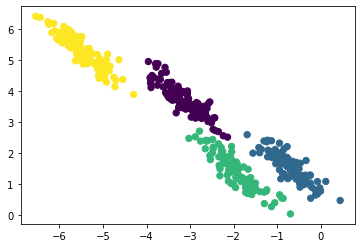

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
X = X_stretched
plt.scatter(X[:, 0], X[:, 1], c=y_true, s=40, cmap='viridis')

In [2]:
from scipy.stats import multivariate_normal

def pdfGaussian(x, mean, cov):
    M = x.shape[0]
    cov_inv = np.linalg.inv(cov)
    a1 = (1/(np.sqrt(np.linalg.det(cov))*np.power(2*np.pi, M/2)))
    a2 = np.exp(-1/2 * (x - mean).T.dot(cov_inv).dot(x - mean))
    return a1 * a2

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

class GMM:
    
    def __init__(self, k, method='k-means', max_iter=100, tol=1e-6):
        self.k = k 
        self.method = method
        self.max_iter = max_iter
        self.tol = tol
    
    def init_centers(self, X):
        
        if self.method == 'random_mean_std':
            
            # generate K random means and stds
            mean_arr = X[np.random.choice(X.shape[0], self.k, replace=False)]
            cov_arr = np.array([np.cov(X.T) / self.k] * self.k)
            pi_arr = np.zeros(self.k, dtype=int)
            for x in X:
                probs = np.array([self.pdf(x, mean, cov) for mean, cov in zip(mean_arr, cov_arr)])
                pi_arr[probs.argmax()] += 1
            pi_arr = pi_arr / sum(pi_arr)
            return mean_arr, cov_arr, pi_arr
        
        if self.method == 'random_mean':
            
            # generate K random means
            mean_arr = X[np.random.choice(X.shape[0], self.k, replace=False)]
            
            clusters = [np.empty((0, 0)) for i in range(self.k)]
            for x in X:
                dists = np.array([np.linalg.norm(x-mean) for mean in mean_arr])
                clusters[dists.argmin()] = np.append(clusters[dists.argmin()], x)
            clusters = [cluster.reshape(-1, X.shape[1]) for cluster in clusters]
            cov_arr = np.array([np.cov(cluster.T) for cluster in clusters])
            
            pi_arr = np.zeros(self.k, dtype=int)
            for x in X:
                probs = np.array([self.pdf(x, mean, cov) for mean, cov in zip(mean_arr, cov_arr)])
                pi_arr[probs.argmax()] += 1
            pi_arr = pi_arr / sum(pi_arr)
            
            return mean_arr, cov_arr, pi_arr
        
        if self.method == 'k-means':
            
            # generate initial points by KMeans algo
            kmeans = KMeans(n_clusters=self.k)
            kmeans.fit(X)
            pred = kmeans.predict(X)
            
            mean_arr = kmeans.cluster_centers_
            cov_arr = np.array([np.cov(X[np.where(pred == k)].T) for k in range(self.k)])
            pi_arr = np.array([X[np.where(pred == k)].shape[0] / X.shape[0] for k in range(self.k)])
            
            return mean_arr, cov_arr, pi_arr
        
        if self.method == 'random_divide':
            
            np.random.shuffle(X)
            samples = np.split(X, self.k, axis=0)
            
            mean_arr = np.array([np.mean(sample, axis=0) for sample in samples])
            
            cov_arr = np.array([np.cov(sample.T) for sample in samples])
            
            pi_arr = np.zeros(self.k, dtype=int)
            for x in X:
                probs = np.array([self.pdf(x, mean, cov) for mean, cov in zip(mean_arr, cov_arr)])
                pi_arr[probs.argmax()] += 1
            pi_arr = pi_arr / sum(pi_arr)
            
            return mean_arr, cov_arr, pi_arr
        
        if self.method == 'random_gammas':
            
            gamma_mtrx = np.random.rand(self.k)
            gamma_mtrx /= gamma_mtrx.sum()
            for _ in range(X.shape[0]-1):
                next_item = np.random.rand(self.k)
                next_item /= next_item.sum()
                gamma_mtrx = np.vstack((gamma_mtrx, next_item))
            return self.maximization(X, gamma_mtrx)
        
    
    def fit(self, X):
        self.mean_arr, self.cov_arr, self.pi_arr = self.init_centers(X)
        self.score = self.loss(X, self.mean_arr, self.cov_arr, self.pi_arr)
        for _ in range(self.max_iter):
            gamma_mtrx = self.expectation(X, self.mean_arr, self.cov_arr, self.pi_arr)
            mean_arr, cov_arr, pi_arr = self.maximization(X, gamma_mtrx)
            loss = self.loss(X, mean_arr, cov_arr, pi_arr)
            if abs(self.score - loss) <= self.tol:
                break
            self.score=loss
            self.mean_arr = mean_arr
            self.cov_arr = cov_arr
            self.pi_arr = pi_arr
            
    def loss(self, X, mean_arr, cov_arr, pi_arr):
        return -sum([np.log(sum([pi * self.pdf(x, mean, cov) for mean, cov, pi in zip(mean_arr, cov_arr, pi_arr)]), ) for x in X])
    
    def pdf(self, x, mean, cov):
        return multivariate_normal(mean, cov).pdf(x)
            
    def expectation(self, X, mean_arr, cov_arr, pi_arr):
        gamma_mtrx = np.zeros((X.shape[0], self.k))
        for i, x in enumerate(X):
            s = sum([pi_arr[j] * self.pdf(x, mean_arr[j], cov_arr[j]) for j in range(self.k)])
            for k in range(self.k):
                gamma_mtrx[i, k] = (pi_arr[k] * self.pdf(x, mean_arr[k], cov_arr[k])) / s
        return gamma_mtrx

    def maximization(self, X, gamma_mtrx):
        Nk = gamma_mtrx.sum(axis=0)
        mean_arr = np.array([np.dot(gamma_mtrx[:,k], X) / (Nk[k]+1e-10) for k in range(self.k)])
        cov_arr = np.array([sum([gamma_mtrx[i, k] * (X[i]-mean_arr[k]).reshape(X.shape[1], -1).dot((X[i]-mean_arr[k]).reshape(-1, X.shape[1])) for i in range(X.shape[0])]) / Nk[k] for k in range(self.k)])
        pi_arr = Nk / X.shape[0]
        return mean_arr, cov_arr, pi_arr    
        
    def predict(self, X):
        return np.array([elem.argmax() for elem in self.expectation(X, self.mean_arr, self.cov_arr, self.pi_arr)])
    
    def predict_proba(self, X):
        return self.expectation(X, self.mean_arr, self.cov_arr, self.pi_arr)

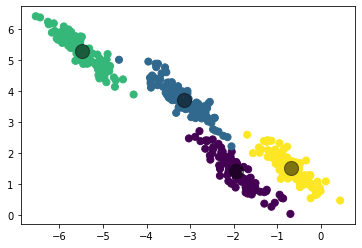

In [4]:
gmm = GMM(k=4, method='k-means')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)

In [5]:
gmm.score

767.3882457144989

In [6]:
gmm.predict_proba(X)

array([[2.35354868e-07, 5.82396892e-01, 4.17602873e-01, 1.50403039e-22],
       [9.99999999e-01, 1.27817292e-09, 1.90419897e-17, 4.44954078e-15],
       [9.99999997e-01, 2.79569429e-09, 2.35019840e-14, 2.85589119e-17],
       ...,
       [1.95973098e-08, 6.50174891e-08, 9.58356208e-37, 9.99999915e-01],
       [4.29461586e-01, 5.70176454e-01, 1.96454728e-15, 3.61960567e-04],
       [5.29434561e-14, 1.96591420e-11, 3.17868479e-47, 1.00000000e+00]])

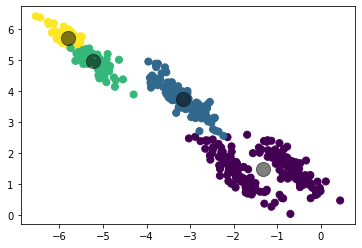

In [7]:
gmm = GMM(k=4, method='random_mean')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)

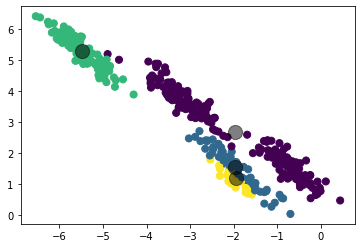

In [8]:
gmm = GMM(k=4, method='random_mean_std')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)

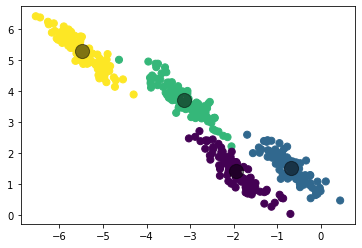

In [9]:
gmm = GMM(k=4, method='random_divide')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)

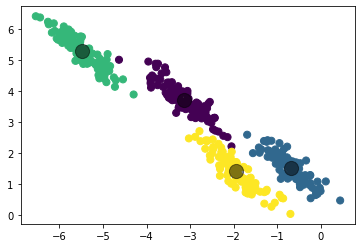

In [10]:
gmm = GMM(k=4, method='random_gammas')
gmm.fit(X)
pred = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, s=50, cmap='viridis')
plt.scatter(gmm.mean_arr[:, 0], gmm.mean_arr[:, 1], c='black', s=200, alpha=0.5)

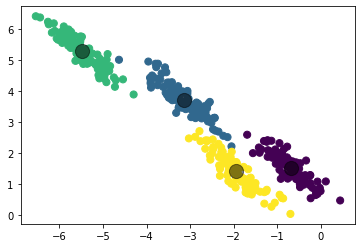

In [11]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=4)
gm.fit(X)
prediction = gm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=prediction, s=50, cmap='viridis')
plt.scatter(gm.means_[:, 0], gm.means_[:, 1], c='black', s=200, alpha=0.5)